In [9]:
import pandas as pd
import numpy as np
import re
import json
import math
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
def load_answers(filepath, answers_df):
    with open(filepath) as f:
        data = json.load(f)

    df = pd.DataFrame(data['questions'])

    if 'question_index' in list(df.columns):
        temp = answers_df.drop(['question'],axis=1)
        df = temp.merge(df, left_index=True, right_on='question_index')
    else:
        df = answers_df.merge(df, right_on='question', left_on='question')
    return df

def category_filter(df, category):
    subset = df[df['Category'] == category].copy()
    return subset


def correct_filter(df, incorrect=False):
    subset = df[(df['correct_answer'] == df['response']) != incorrect].copy()
    return subset

In [11]:
def correct(df):
    df['correct'] = df['correct_answer'] == df['response']
    return df['correct'].sum()

def accuracy(df):
    df['correct'] = df['correct_answer'] == df['response']
    return df['correct'].sum() / len(df['correct'])

def expected_correct(df):
    df['expected_correct'] = df.apply(lambda x: math.exp(x['clls'][['A','B','C','D','E'].index(x['correct_answer'])]),axis=1)
    return df['expected_correct'].sum()

def expected_accuracy(df):
    df['expected_correct'] = df.apply(lambda x: math.exp(x['clls'][['A','B','C','D','E'].index(x['correct_answer'])]),axis=1)
    return df['expected_correct'].sum()/len(df)


In [12]:
def IOD_correl(df):
    expected_correct = df.apply(lambda x: math.exp(x['clls'][['A','B','C','D','E'].index(x['correct_answer'])]),axis=1)
    expected_correct[expected_correct.isna()] = 0.0
    return stats.pearsonr(df['IOD'],expected_correct)
    
def DI_correl(df):
    expected_correct = df.apply(lambda x: math.exp(x['clls'][['A','B','C','D','E'].index(x['correct_answer'])]),axis=1)
    expected_correct[expected_correct.isna()] = 0.0
    return stats.pearsonr(df['MD'],expected_correct)
    
def human_correl(df):
    expected_correct = df.apply(lambda x: math.exp(x['clls'][['A','B','C','D','E'].index(x['correct_answer'])]),axis=1)
    expected_correct[expected_correct.isna()] = 0.0
    human_correct = df.apply(lambda x: x['%'+str(x['Answer'])],axis=1) # this Answer column comes from the master report rather than from the 
    return stats.pearsonr(human_correct,expected_correct)

def pairwise_correl(df1,df2):
    expected_correct1 = df1.apply(lambda x: math.exp(x['clls'][['A','B','C','D','E'].index(x['correct_answer'])]),axis=1)
    expected_correct1[expected_correct1.isna()] = 0.0
    expected_correct2 = df2.apply(lambda x: math.exp(x['clls'][['A','B','C','D','E'].index(x['correct_answer'])]),axis=1)
    expected_correct2[expected_correct2.isna()] = 0.0
    return stats.pearsonr(expected_correct1,expected_correct2)
    

In [13]:
def simple_tokenizer(text):
    return text.split()

def logres(df):
    df['token_count'] = df['question'].apply(simple_tokenizer).apply(len)

    X = sm.add_constant(np.log(df['token_count']))
    y = df.apply(lambda x: math.exp(x['clls'][['A','B','C','D','E'].index(x['correct_answer'])]),axis=1)
    y[y.isna()] = 0.0

    logres = sm.Logit(y,X).fit()
    return {'statistic':logres.params.iloc[1], 'pvalue':logres.pvalues.iloc[1]}

def calibration(df):
    df['accuracy'] = df.apply(lambda x: 1.0 if (x['response'] == x['correct_answer']) else 0.0,axis=1)

    X = sm.add_constant(df['accuracy'])
    y = df.apply(lambda x: math.exp(max(x['clls'])),axis=1)
    y[y.isna()] = 0.0

    logres = sm.Logit(y,X).fit()    
    return {'statistic':logres.params.iloc[1], 'pvalue':logres.pvalues.iloc[1]}

In [14]:
def weight_dist(df):
    sorted_clls = pd.DataFrame(df['clls'].apply(lambda x: np.exp(np.array(sorted(x,reverse=True)))).tolist())
    return (sorted_clls.sum() / len(df)).values


In [15]:
answers_df = pd.read_csv('../../data/blac0817/data/master_questions.csv').set_index('Unnamed: 0')
answers_df.index.name = 'questions_index'

def format_prompt(row):
        text = f"Answer the following multiple choice question by giving the most appropriate response. The answer should be one of [A, B, C, D, E]. Question: {row['prompt']} A) {row['A']} B) {row['B']} C) {row['C']} D) {row['D']} E) {row['E']}"
        return text

answers_df['question'] = answers_df[['prompt', 'A', 'B', 'C', 'D', 'E']].apply(format_prompt,axis=1)
categories = list(set(answers_df['Category'].values))
categories.sort()

In [16]:
models = {#'GPT 4 Turbo': 'gpt-4-1106-preview',
          #'GPT 3.5': 'gpt-3.5-turbo-1106',
          #'PaLM 2': 'text-bison@002',
          'Mistral 8x7B': 'Mixtral-8x7B-v0.1',
          #'Med42': 'med42-70b',
          #'Med42': 'med42-70b_randomized', 
          #'Meditron 70B': 'meditron-70b', 
          #'Meditron 70B': 'meditron-70b_randomized',
          'Meditron 7B': 'meditron-7b',
          #'Meditron 7B': 'meditron-7b_randomized',
          #'Llama 2 70B':  'Llama-2-70b-chat-hf',
          #'Llama 2 70B':  'Llama-2-70b-chat-hf_randomized',
          #'Llama 2 13B': 'Llama-2-13b-chat-hf',
          #'Llama 2 13B':  'Llama-2-13b-chat-hf_randomized',
          'Llama 2 7B':  'Llama-2-7b-chat-hf',
          #'Llama 2 7B':  'Llama-2-7b-chat-hf_randomized',
          #'Phi 2': 'phi-2',
          #'Phi 2': 'phi-2_randomized',
          #'Vicuna 1.5 7B': 'vicuna-7b-v1.5',
          #'Vicuna 1.5 13B': 'vicuna-13b-v1.5',
          'Gemma 7B': 'gemma-7b-it',
          }

models_df = pd.DataFrame.from_dict(models, columns = ['hf_name'], orient='index')

models_df['filepath'] = '../../data/blac0817/responses/' + models_df['hf_name'] + '.json'

models_df['n_correct'] = models_df.apply(lambda x: correct(load_answers(x['filepath'], answers_df)),axis=1) 
models_df['raw_accuracy'] = models_df.apply(lambda x: accuracy(load_answers(x['filepath'], answers_df)),axis=1) 
models_df['expected_correct'] = models_df.apply(lambda x: expected_correct(load_answers(x['filepath'], answers_df)),axis=1)
models_df['expected_accuracy'] = models_df.apply(lambda x: expected_accuracy(load_answers(x['filepath'], answers_df)),axis=1)


for category in categories:
    models_df[category+'_n_correct'] = models_df.apply(lambda x: correct(category_filter(load_answers(x['filepath'], answers_df),category)),axis=1) 
    models_df[category+'_raw_accuracy'] = models_df.apply(lambda x: accuracy(category_filter(load_answers(x['filepath'], answers_df),category)),axis=1) 
    models_df[category+'_expected_correct'] = models_df.apply(lambda x: expected_correct(category_filter(load_answers(x['filepath'], answers_df),category)),axis=1)
    models_df[category+'_expected_accuracy'] = models_df.apply(lambda x: expected_accuracy(category_filter(load_answers(x['filepath'], answers_df),category)),axis=1)

models_df['IOD_correl'] = models_df.apply(lambda x: IOD_correl(load_answers(x['filepath'], answers_df)),axis=1)
models_df['DI_correl'] = models_df.apply(lambda x: DI_correl(load_answers(x['filepath'], answers_df)),axis=1)
models_df['human_correl'] = models_df.apply(lambda x: human_correl(load_answers(x['filepath'], answers_df)),axis=1)

models_df['length_regr'] = models_df.apply(lambda x: logres(load_answers(x['filepath'], answers_df)),axis=1)
models_df['calibration'] = models_df.apply(lambda x: calibration(load_answers(x['filepath'], answers_df)),axis=1)

models_df['weight_dist'] = models_df.apply(lambda x: weight_dist(load_answers(x['filepath'], answers_df)),axis=1) 
models_df['correct_weight_dist'] = models_df.apply(lambda x: weight_dist(correct_filter(load_answers(x['filepath'], answers_df))),axis=1) 
models_df['incorrect_weight_dist'] = models_df.apply(lambda x: weight_dist(correct_filter(load_answers(x['filepath'], answers_df),incorrect=True)),axis=1) 


Optimization terminated successfully.
         Current function value: 0.683384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.407354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.446955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544094
         Iterations 5


In [17]:
def human_correct(df):
    return df.apply(lambda x: x['%'+str(x['Answer'])],axis=1).sum()/100

def human_accuracy(df):
    return human_correct(df)/len(df)

In [18]:
human_df = pd.DataFrame(index=['Human'], columns = models_df.columns)

human_df['n_correct']['Human'] = human_correct(answers_df)
human_df['raw_accuracy']['Human'] = human_accuracy(answers_df)
human_df['expected_correct']['Human'] = human_df['n_correct']['Human']
human_df['expected_accuracy']['Human'] = human_df['raw_accuracy']['Human']

for c in categories:
    human_df[c+'_n_correct']['Human'] = human_correct(category_filter(answers_df,c))
    human_df[c+'_raw_accuracy']['Human'] = human_accuracy(category_filter(answers_df,c))
    human_df[c+'_expected_correct']['Human'] = human_df[c+'_n_correct']['Human']
    human_df[c+'_expected_accuracy']['Human'] = human_df[c+'_raw_accuracy']['Human']


/tmp/ipykernel_3636929/354988212.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  human_df['n_correct']['Human'] = human_correct(answers_df)
/tmp/ipykernel_3636929/354988212.py:4: FutureWarning: ChainedAssignmentError: behaviour will chan

In [19]:
total_df = pd.concat([human_df,models_df])

In [20]:
pairwise_df = pd.DataFrame(index = models.keys(), columns = models.keys())

for m1 in models.keys():
    for m2 in models.keys():
        pairwise_df[m1][m2] = pairwise_correl(load_answers('./responses/'+models[m1]+'.json', answers_df),load_answers('./responses/'+models[m2]+'.json', answers_df))


/tmp/ipykernel_3636929/3423729099.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pairwise_df[m1][m2] = pairwise_correl(load_answers('./responses/'+models[m1]+'.json', answers_df),load_answers('./responses/'+models[m2]+'.json', answers_d

In [21]:
core_models = list(models_df.index.values)
#[ 'GPT 4 Turbo', 'GPT 3.5','PaLM 2', 'Mistral 8x7B','Med42', 'Meditron 70B','Llama 2 70B','Phi 2',]

### Table 1: Accuracy by Category

In [22]:
acc_by_category = pd.DataFrame(index=categories+['All'], columns= ['Count','Human'] + core_models)

for m in core_models+['Human']:
    for c in categories:
        acc_by_category[m][c] = total_df[c+'_raw_accuracy'][m]

    acc_by_category[m]['All'] = total_df['raw_accuracy'][m]

for c in categories: 
    acc_by_category['Count'][c] = (answers_df['Category'] == c).sum()

acc_by_category['Count']['All'] = len(answers_df)

/tmp/ipykernel_3636929/229675384.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  acc_by_category[m][c] = total_df[c+'_raw_accuracy'][m]
/tmp/ipykernel_3636929/229675384.py:7: FutureWarning: ChainedAssignmentError: behaviour will change i

In [23]:
ex_acc_by_category = pd.DataFrame(index=categories+['All'], columns= ['Count', 'Human'] + list(core_models))

for m in core_models+['Human']:
    for c in categories:
        ex_acc_by_category[m][c] = total_df[c+'_expected_accuracy'][m]

    ex_acc_by_category[m]['All'] = total_df['expected_accuracy'][m]

for c in categories: 
    ex_acc_by_category['Count'][c] = (answers_df['Category'] == c).sum()

ex_acc_by_category['Count']['All'] = len(answers_df)

/tmp/ipykernel_3636929/591618673.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ex_acc_by_category[m][c] = total_df[c+'_expected_accuracy'][m]
/tmp/ipykernel_3636929/591618673.py:7: FutureWarning: ChainedAssignmentError: behaviour will 

In [24]:
ordered_categories = ['ID','PD','GS','OB','FAM','PS','EM','BL','MR','PH','All']

In [25]:
# formatting

def as_percent(x):
    return round(100*x,1)
    
def make_pretty(styler):
    styler.format(as_percent, subset=list(core_models))
    #styler.set_caption("Answer Accuracy")
    #styler.background_gradient(subset=list(total_df.index.values), axis=1)
    return styler

acc_by_category.reindex(ordered_categories).style.pipe(make_pretty)

,Count,Human,Mistral 8x7B,Meditron 7B,Llama 2 7B,Gemma 7B
ID,168,0.832995,64.3,39.3,31.5,25.0
PD,126,0.814690,65.9,27.8,28.6,16.7
GS,118,0.821720,66.9,26.3,37.3,22.9
OB,124,0.831145,66.9,21.0,39.5,22.6
FAM,87,0.816149,48.3,26.4,37.9,23.0
PS,61,0.755820,62.3,29.5,42.6,11.5
EM,79,0.828962,72.2,25.3,36.7,20.3
BL,46,0.835913,60.9,39.1,39.1,19.6
MR,31,0.841129,45.2,16.1,19.4,19.4
PH,34,0.822559,82.4,38.2,58.8,23.5


In [26]:
def make_pretty(styler):
    styler.format(as_percent, subset=list(core_models))
    styler.set_caption("Expected Answer Accuracy")
    #styler.background_gradient(subset=list(core_models), axis=1)
    return styler

ex_acc_by_category.reindex(ordered_categories).style.pipe(make_pretty)

,Count,Human,Mistral 8x7B,Meditron 7B,Llama 2 7B,Gemma 7B
ID,168,0.832995,51.4,23.1,30.7,25.2
PD,126,0.814690,52.1,22.1,26.5,18.4
GS,118,0.821720,51.6,21.8,35.5,25.1
OB,124,0.831145,53.3,21.3,38.5,20.6
FAM,87,0.816149,42.2,21.4,35.3,20.5
PS,61,0.755820,53.8,23.3,38.9,16.8
EM,79,0.828962,56.8,22.0,33.8,20.1
BL,46,0.835913,43.7,22.2,36.7,21.2
MR,31,0.841129,36.4,20.2,18.7,15.9
PH,34,0.822559,65.8,23.7,53.0,18.8


In [27]:
def make_pretty(styler):
    styler.format(as_percent, subset=(list(total_df.index.values)))
    styler.set_caption("Expected Answer Accuracy Decrease")
    #styler.background_gradient(subset=list(total_df.index.values), axis=1)
    return styler

(acc_by_category - ex_acc_by_category).style.pipe(make_pretty)

,Count,Human,Mistral 8x7B,Meditron 7B,Llama 2 7B,Gemma 7B
BL,0,0.0,17.2,17.0,2.4,-1.7
EM,0,0.0,15.3,3.3,2.9,0.1
FAM,0,0.0,6.1,5.0,2.7,2.5
GS,0,0.0,15.3,4.5,1.7,-2.2
ID,0,0.0,12.9,16.2,0.9,-0.2
MR,0,0.0,8.8,-4.0,0.7,3.5
OB,0,0.0,13.6,-0.3,1.0,2.0
PD,0,0.0,13.7,5.7,2.1,-1.7
PH,0,0.0,16.6,14.5,5.9,4.8
PS,0,0.0,8.5,6.2,3.8,-5.3


### Table 2: Correlation of Accuracy and Question Difficulty

In [28]:
correl_with_diff = pd.DataFrame(index=['IOD','DI','Human'], columns= core_models)

for m in core_models:
    correl_with_diff[m]['IOD'] = models_df['IOD_correl'][m]
    correl_with_diff[m]['DI'] = models_df['DI_correl'][m]
    correl_with_diff[m]['Human'] = models_df['human_correl'][m]



/tmp/ipykernel_3636929/4101767569.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  correl_with_diff[m]['IOD'] = models_df['IOD_correl'][m]
/tmp/ipykernel_3636929/4101767569.py:5: FutureWarning: ChainedAssignmentError: behaviour will chang

In [29]:
# formatting

def parse_correls(c):
    if c.pvalue < 0.05:
        return f'{round(c.statistic,2):.2f}*'
    else:
        return f'{round(c.statistic,2):.2f} '

def make_pretty(styler):
    styler.format(parse_correls)
    styler.set_caption("test")
    return styler


correl_with_diff.style.pipe(make_pretty)

,Mistral 8x7B,Meditron 7B,Llama 2 7B,Gemma 7B
IOD,0.13*,-0.01,0.02,0.02
DI,-0.23*,-0.11*,-0.15*,-0.07*
Human,0.25*,0.09*,0.08*,0.08*


### Table 3: Pairwise Model Correlations

In [30]:
pairwise_df.drop('Phi 2').apply(lambda x: round(sorted(x.values)[-2].statistic,2))

KeyError: "['Phi 2'] not found in axis"

In [ ]:
# make a correlation dendrogram of these

def parse_correls(c):
    if c.pvalue < 0.05:
        return f'{round(c.statistic,2):.2f}*'
    else:
        return f'{round(c.statistic,2):.2f}'


def make_pretty(styler):
    styler.format(parse_correls)
    styler.set_caption("test")
    styler.background_gradient()
    return styler


pairwise_df.style.pipe(make_pretty)

,GPT 4 Turbo,GPT 3.5,PaLM 2,Mistral 8x7B,Med42,Meditron 70B,Meditron 7B,Llama 2 70B,Llama 2 13B,Llama 2 7B,Phi 2
GPT 4 Turbo,1.00*,0.43*,0.44*,0.46*,0.40*,0.29*,0.15*,0.33*,0.22*,0.18*,0.05
GPT 3.5,0.43*,1.00*,0.51*,0.59*,0.45*,0.33*,0.20*,0.41*,0.33*,0.22*,0.01
PaLM 2,0.44*,0.51*,1.00*,0.62*,0.52*,0.44*,0.20*,0.49*,0.43*,0.32*,-0.04
Mistral 8x7B,0.46*,0.59*,0.62*,1.00*,0.57*,0.56*,0.32*,0.52*,0.50*,0.38*,0.04
Med42,0.40*,0.45*,0.52*,0.57*,1.00*,0.39*,0.25*,0.40*,0.37*,0.23*,0.00
Meditron 70B,0.29*,0.33*,0.44*,0.56*,0.39*,1.00*,0.24*,0.50*,0.48*,0.49*,0.11*
Meditron 7B,0.15*,0.20*,0.20*,0.32*,0.25*,0.24*,1.00*,0.20*,0.27*,0.26*,0.13*
Llama 2 70B,0.33*,0.41*,0.49*,0.52*,0.40*,0.50*,0.20*,1.00*,0.53*,0.37*,-0.11*
Llama 2 13B,0.22*,0.33*,0.43*,0.50*,0.37*,0.48*,0.27*,0.53*,1.00*,0.48*,-0.08*
Llama 2 7B,0.18*,0.22*,0.32*,0.38*,0.23*,0.49*,0.26*,0.37*,0.48*,1.00*,0.08*


In [ ]:
pairwise_df_flat = pairwise_df.map(lambda x: x.statistic)
pairwise_df_flat.drop(['Meditron 7B', 'Llama 2 13B', 'Llama 2 7B'], inplace=True)
pairwise_df_flat.drop(['Meditron 7B', 'Llama 2 13B', 'Llama 2 7B'], inplace=True, axis=1)

In [ ]:
def make_pretty(styler):
    styler.format(precision=2)
    styler.set_caption("test")
    styler.background_gradient()
    return styler

pairwise_df_flat.style.pipe(make_pretty)

,GPT 4 Turbo,GPT 3.5,PaLM 2,Mistral 8x7B,Med42,Meditron 70B,Llama 2 70B,Phi 2
GPT 4 Turbo,1.00,0.43,0.44,0.46,0.40,0.29,0.33,0.05
GPT 3.5,0.43,1.00,0.51,0.59,0.45,0.33,0.41,0.01
PaLM 2,0.44,0.51,1.00,0.62,0.52,0.44,0.49,-0.04
Mistral 8x7B,0.46,0.59,0.62,1.00,0.57,0.56,0.52,0.04
Med42,0.40,0.45,0.52,0.57,1.00,0.39,0.40,0.00
Meditron 70B,0.29,0.33,0.44,0.56,0.39,1.00,0.50,0.11
Llama 2 70B,0.33,0.41,0.49,0.52,0.40,0.50,1.00,-0.11
Phi 2,0.05,0.01,-0.04,0.04,0.00,0.11,-0.11,1.00


<Axes: >

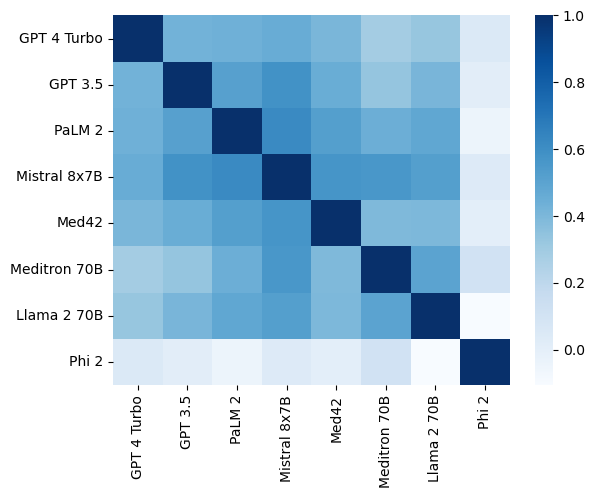

In [ ]:
sns.heatmap(pairwise_df_flat, cmap='Blues')#col_cluster=False)

### Table 4: Logistic Regression

In [ ]:
logres = pd.DataFrame(index=['ln(words)'], columns= list(models_df.index.values))

for m in models_df.index.values:
    logres[m]['ln(words)'] = models_df['length_regr'][m]



In [ ]:

def parse_correls(c):
    if c['pvalue'] < 0.05:
        return f"{round(c['statistic'],2):.2f}*"
    else:
        return f"{round(c['statistic'],2):.2f} "

def make_pretty(styler):
    styler.format(parse_correls)
    styler.set_caption("test")
    return styler

logres.style.pipe(make_pretty)

,GPT 4 Turbo,GPT 3.5,PaLM 2,Mistral 8x7B,Med42,Meditron 70B,Meditron 7B,Llama 2 70B,Llama 2 13B,Llama 2 7B,Phi 2
ln(words),-0.57*,-0.57*,-0.37*,-0.49*,-0.41*,-0.16,-0.05,-0.13,-0.15,-0.15,0.18


### Calibration

In [ ]:
calib = pd.DataFrame(index=['max_logit'], columns= list(models_df.index.values))

for m in models_df.index.values:
    calib[m]['max_logit'] = models_df['calibration'][m]




In [ ]:
def parse_correls(c):
    if c['pvalue'] < 0.05:
        return f"{round(c['statistic'],2):.2f}*"
    else:
        return f"{round(c['statistic'],2):.2f} "

def make_pretty(styler):
    styler.format(parse_correls)
    styler.set_caption("test")
    return styler

calib.style.pipe(make_pretty)

,GPT 4 Turbo,GPT 3.5,PaLM 2,Mistral 8x7B,Med42,Meditron 70B,Meditron 7B,Llama 2 70B,Llama 2 13B,Llama 2 7B,Phi 2
max_logit,1.85*,1.35*,0.77*,0.78*,1.08*,0.66*,0.11,1.08*,0.75*,0.47*,0.21


### Table 5: Pred Weight Distributions

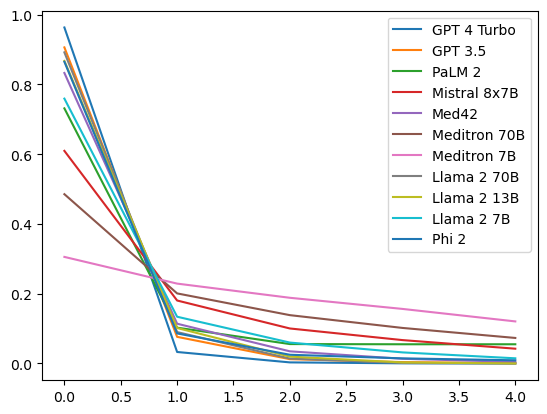

In [ ]:
temp = pd.DataFrame(np.array(models_df['weight_dist'].tolist()).T,columns = models_df.index.values)
temp.plot()
plt.legend()
plt.show()

In [ ]:
temp

,GPT 4 Turbo,GPT 3.5,PaLM 2,Mistral 8x7B,Med42,Meditron 70B,Meditron 7B,Llama 2 70B,Llama 2 13B,Llama 2 7B,Phi 2
0,0.963229,0.906118,0.731327,0.609516,0.832826,0.485328,0.305538,0.891893,0.867407,0.759301,0.864888
1,0.033008,0.076388,0.102749,0.180563,0.114061,0.200919,0.229009,0.090049,0.101762,0.134045,0.086157
2,0.003161,0.012457,0.055698,0.100403,0.034903,0.138608,0.188375,0.014151,0.019741,0.059972,0.025051
3,0.000500,0.003967,0.055113,0.067069,0.013473,0.101924,0.156428,0.001540,0.003026,0.031812,0.014716
4,0.000101,0.001070,0.055113,0.042449,0.004737,0.073221,0.120651,0.000078,0.000055,0.014871,0.009188


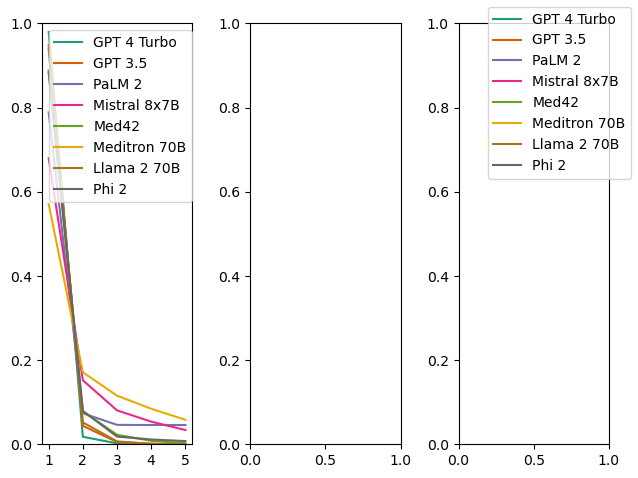

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=3)

temp = pd.DataFrame(np.array(models_df['correct_weight_dist'].tolist()).T,
                    columns = models_df.index.values, index = [1,2,3,4,5])
temp.drop(['Meditron 7B', 'Llama 2 13B', 'Llama 2 7B'],inplace=True,axis=1)
temp.plot(ax = axs[0], kind = 'line', xticks = [1,2,3,4,5], colormap='Dark2', ylim = (0,1))
fig.legend()
fig.tight_layout()
plt.show()


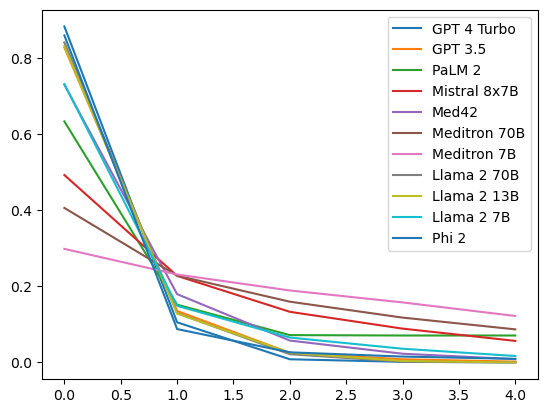

In [ ]:
temp = pd.DataFrame(np.array(models_df['incorrect_weight_dist'].tolist()).T,columns = models_df.index.values)
temp.plot()
plt.legend()
plt.show()


### Shuffle check

In [ ]:


base = load_answers(models_df['filepath']['Med42'], answers_df)
rand = load_answers(models_df['filepath']['Med42 R'], answers_df)

KeyError: 'Med42 R'

In [ ]:
def translate_shuffle(row):
    choices = ['A','B','C','D','E']
    unmap = {c: choices[int(row['shuffle'][i])] for i,c in enumerate(choices)}
    top3 = [unmap[i] for i in row['top3']]
    response = unmap[row['response']]
    correct_answer = unmap[row['correct_answer']]
    clls = [row['clls'][row['shuffle'].index(i)] for i in range(5)]
    return pd.Series([top3, response, correct_answer, clls], index=['top3','response','correct_answer','clls'])

unrand = rand.apply(translate_shuffle,axis=1) 

In [ ]:
unrand_correct = unrand['response'] == unrand['correct_answer']
base_correct = base['response'] == base['correct_answer']

cm = np.array([[0,0],[0,0]])

cm[0,0] = sum(unrand_correct & base_correct)
cm[0,1] = sum(unrand_correct & ~base_correct)
cm[1,0] = sum(~unrand_correct & base_correct)
cm[1,1] = sum(~unrand_correct & ~base_correct)

confusion_matrix = pd.DataFrame(cm)

def make_pretty(styler):
    styler.set_caption("Confusion Matrix")
    styler.background_gradient()
    return styler

(cm[0,0] + cm[1,1])/len(unrand)
print(f'{(cm[0,0] + cm[1,1])/len(unrand)*100}% on diagonal')

confusion_matrix.style.pipe(make_pretty)

76.88787185354691% on diagonal


,0,1
0,467,99
1,103,205
